In [10]:
import os

In [11]:
%pwd

'e:\\GCET\\Machine Learning\\Deep Learning Projects\\text_recognition\\research'

In [12]:
os.chdir('../')

In [13]:
%pwd

'e:\\GCET\\Machine Learning\\Deep Learning Projects\\text_recognition'

In [25]:
from pathlib import Path
dataset_dir='artifacts/Dataset/Word_Level_Training_Set/'

In [17]:
import cv2
import numpy as np

def resize_image(img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR):
    height,width,channels=img.shape
    target_height32=canvas_size[0]
    target_width128=canvas_size[1]

    if width>height:
        temp_ratio=target_width128/width
        if int(temp_ratio*height)>target_height32:
            ratio=target_height32/height
        else:
            ratio=temp_ratio
    else:
        temp_ratio=target_height32/height
        if int(temp_ratio*width)>target_width128:
            ratio=target_width128/width
        else:
            ratio=temp_ratio
    target_h=int(ratio*height)
    target_w=int(ratio*width)
    #proc=cv2.resize(img,(target_w,target_h),interpolation=interpolation)
    proc=cv2.resize(img,(256,64),interpolation=interpolation) #orignial resize img is (128,32)
    proc=np.expand_dims(proc, axis=-1)

    #resized=np.zeros((target_height32, target_width128, channels),dtype=np.float32)
    #resized[:target_h,:target_w]=proc

    return proc


In [26]:
initial_img_path=[]
initial_text_label=[]

with open(os.path.join(dataset_dir,'train_filtered.txt'), "r", encoding="utf-8") as file:
    lines = file.readlines()
    for i,line in enumerate(lines):
        try:
            path=line.split("\t")[0]
            label=line.split("\t")[1][:-1]
        except Exception as e:
            print(e," ",i," ",line)

        initial_img_path.append(os.path.join(dataset_dir,path))
        initial_text_label.append(label)

In [44]:
max_label_len=max(len(label) for label in initial_text_label)
max_label_len

15

In [28]:
vocab=set("".join(map(str,initial_text_label)))
vocab.add('X')  #because X is not there in filtered images(removed cropped and bad images from the directory)

vocab=[char for char in vocab if char.isalnum()]
char_list=sorted(vocab)
print(len(char_list))
print(char_list)

62
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [37]:
img_path=[]
text_labels=[]

for i,(path,label) in enumerate(zip(initial_img_path,initial_text_label)):
    if all(char in char_list for char in label):
        img_path.append(path)
        text_labels.append(label)

In [38]:
print(len(img_path),len(text_labels))

34522 34522


In [39]:
img_path=img_path[:30000]
text_labels=text_labels[:30000]

In [14]:
print(len(img_path),len(text_labels))

30000 30000


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
import cv2

def encode_to_label(txt):
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
    
    return pad_sequences([dig_lst], maxlen=26, padding='post', value=len(char_list))[0] #maxlen earlier was max_label_len

def get_image(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    img = cv2.bitwise_not(img)

    img = np.expand_dims(img, axis=-1)

    img=resize_image(img)

    blur = cv2.GaussianBlur(img, (1,1), 0)

    _, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img = binary_img.astype(np.float32) / 255.0  

    kernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness

    # Apply dilation to thicken text
    thickened_text = cv2.dilate(img, kernel, iterations=1)

    thickened_text = np.expand_dims(thickened_text, axis=-1)

    img_tensor = tf.convert_to_tensor(thickened_text, dtype=tf.float32)

    return img_tensor

In [18]:
""" img_exp = cv2.imread('artifacts/Dataset/Word_Level_Training_Set/image/12155_3.jpg', cv2.IMREAD_GRAYSCALE)

img_exp = cv2.bitwise_not(img_exp)

kernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness

# Apply dilation to thicken text
thickened_text = cv2.dilate(img_exp, kernel, iterations=1)

thickened_text = np.expand_dims(thickened_text, axis=-1)



#img_exp = cv2.adaptiveThreshold(img_exp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                            cv2.THRESH_BINARY, 15, 2) 

blur = cv2.GaussianBlur(thickened_text, (5,5), 0)

# Apply Otsu’s thresholding
_, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#_, binary_img = cv2.threshold(thickened_text, 127, 255, cv2.THRESH_BINARY)  """

" img_exp = cv2.imread('artifacts/Dataset/Word_Level_Training_Set/image/12155_3.jpg', cv2.IMREAD_GRAYSCALE)\n\nimg_exp = cv2.bitwise_not(img_exp)\n\nkernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness\n\n# Apply dilation to thicken text\nthickened_text = cv2.dilate(img_exp, kernel, iterations=1)\n\nthickened_text = np.expand_dims(thickened_text, axis=-1)\n\n\n\n#img_exp = cv2.adaptiveThreshold(img_exp, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, \n#                            cv2.THRESH_BINARY, 15, 2) \n\nblur = cv2.GaussianBlur(thickened_text, (5,5), 0)\n\n# Apply Otsu’s thresholding\n_, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)\n#_, binary_img = cv2.threshold(thickened_text, 127, 255, cv2.THRESH_BINARY)  "

In [19]:
""" import matplotlib.pyplot as plt

plt.imshow(binary_img, cmap='gray')  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show()  """

" import matplotlib.pyplot as plt\n\nplt.imshow(binary_img, cmap='gray')  # Use cmap='gray' for grayscale images if needed\nplt.axis('off')  # Remove axes for better visualization\nplt.show()  "

In [20]:
""" import matplotlib.pyplot as plt

idx=0
temp_img=get_image(img_path[idx])
print(img_path[idx],text_labels[idx])

plt.imshow(temp_img, cmap='gray')  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show()    """

" import matplotlib.pyplot as plt\n\nidx=0\ntemp_img=get_image(img_path[idx])\nprint(img_path[idx],text_labels[idx])\n\nplt.imshow(temp_img, cmap='gray')  # Use cmap='gray' for grayscale images if needed\nplt.axis('off')  # Remove axes for better visualization\nplt.show()    "

In [21]:
""" plt.figure(figsize=(8, 6))
plt.hist(temp_img.flatten(), bins=256, range=(0, 1), color='blue', alpha=0.7)
plt.title("Histogram of Pixel Intensities")
plt.xlabel("Pixel Intensity (0-255)")
plt.ylabel("Frequency")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show() """

' plt.figure(figsize=(8, 6))\nplt.hist(temp_img.flatten(), bins=256, range=(0, 1), color=\'blue\', alpha=0.7)\nplt.title("Histogram of Pixel Intensities")\nplt.xlabel("Pixel Intensity (0-255)")\nplt.ylabel("Frequency")\nplt.grid(axis="y", linestyle="--", alpha=0.7)\nplt.show() '

In [22]:
encoded_labels=list(map(encode_to_label,text_labels))

In [23]:
from sklearn.model_selection import train_test_split

train_img_path,test_img_path,train_encoded_labels,test_encoded_labels=train_test_split(img_path,encoded_labels,test_size=0.25, random_state=42)

In [24]:
""" def combine_inputs(path,label):
    img=get_image(path)

    return {'image':img,'label':label} """

" def combine_inputs(path,label):\n    img=get_image(path)\n\n    return {'image':img,'label':label} "

In [25]:
X_train=list(map(get_image,train_img_path))
y_train=train_encoded_labels

X_test=list(map(get_image,test_img_path))
y_test=test_encoded_labels

In [26]:
batch_size=100

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda img,label: {'image':img,'label':label}, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(lambda img,label: {'image':img,'label':label}, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [27]:
#min(np.array(X_train).shape)

#min(shp.shape for shp in X_train)
X_train[-1].shape

TensorShape([64, 256, 1])

# **Model**

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
    

In [22]:
from itertools import groupby
def ctc_decoder(predictions):
    '''
    input: given batch of predictions from text rec model
    output: return lists of raw extracted text

    '''
    text_list = []
    
    pred_indcies = np.argmax(predictions, axis=2)
    
    for i in range(pred_indcies.shape[0]):
        ans = ""
        
        ## merge repeats
        merged_list = [k for k,_ in groupby(pred_indcies[i])]
        
        ## remove blanks
        for p in merged_list:
            if p != len(char_list):
                ans += char_list[int(p)]
        
        text_list.append(ans)
        
    return text_list

In [17]:
class CTCLayer(layers.Layer):

    def __init__(self, name=None,**kwargs):

        super().__init__(name=name,**kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.

        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [31]:
# model 1
""" def crnn():
    inputs=Input(shape=(128,128,1),name='image')
    labels=Input(shape=(None,),name='label',dtype='float32')

    c1=Conv2D(64,(3,3),padding='same',activation='relu')(inputs)
    b1=BatchNormalization()(c1)
    p1=MaxPool2D(pool_size=(2,2))(b1)

    c2=Conv2D(128,(3,3),padding='same',activation='relu')(p1)
    b2=BatchNormalization()(c2)
    p2=MaxPool2D(pool_size=(2,1))(b2)

    c3=Conv2D(256,(3,3),padding='same',activation='relu')(p2)
    b3=BatchNormalization()(c3)
    p3=MaxPool2D(pool_size=(2,2))(b3)

    c4=Conv2D(512,(3,3),padding='same',activation='relu')(p3)
    b4=BatchNormalization()(c4)
    p4=MaxPool2D(pool_size=(2,1))(b4)

    c5=Conv2D(256,(3,3),padding='same',activation='relu')(p4)
    b5=BatchNormalization()(c5)
    p5=MaxPool2D(pool_size=(2,1))(b5)

    c6=Conv2D(256,(3,3),padding='same',activation='relu')(p5)
    b6=BatchNormalization()(c6)
    p6=MaxPool2D(pool_size=(2,1))(b6)

    c7=Conv2D(64,(3,3),padding='same',activation='relu')(p6)
    #b7=BatchNormalization()(c7)
    p7=MaxPool2D(pool_size=(2,1))(c7) #(batch_size,1,32,64)

    squeezed=Lambda(lambda x: K.squeeze(x, 1))(p7) #(batch_size,32,64)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output=CTCLayer(name='ctc_loss')(labels,softmax_output)

    model=Model(inputs=[inputs,labels],outputs=output)

    return model
"""

# model 2
""" def crnn():
    inputs = Input(shape=(64, 128, 1), name="image")


    labels = layers.Input(name="label", shape=(None,), dtype="float32")


    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)


    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    pool_3=MaxPool2D(pool_size=(2, 1))(conv_3)

    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    batch_norm_5 = BatchNormalization()(conv_5)
    pool_5=MaxPool2D(pool_size=(2, 1))(batch_norm_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu", padding='same')(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)


    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)


    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model
 """

# model 3
""" def crnn():
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model    """

# model 4
""" def crnn():
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(64, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(64, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model """

# model 5
""" def crnn():
    inputs=Input(shape=(32,128,1),name='image')
    labels=Input(shape=(None,),name='label',dtype='float32')

    c1=Conv2D(32,(3,3),padding='same',activation='relu')(inputs)
    b1=BatchNormalization()(c1)
    p1=MaxPool2D(pool_size=(2,2))(b1)

    c2=Conv2D(64,(3,3),padding='same',activation='relu')(p1)
    b2=BatchNormalization()(c2)
    p2=MaxPool2D(pool_size=(2,1))(b2)

    c3=Conv2D(64,(3,3),padding='same',activation='relu')(p2)
    b3=BatchNormalization()(c3)
    p3=MaxPool2D(pool_size=(2,2))(b3)

    c4=Conv2D(128,(3,3),padding='same',activation='relu')(p3)
    b4=BatchNormalization()(c4)
    p4=MaxPool2D(pool_size=(2,1))(b4)

    c5=Conv2D(256,(3,3),padding='same',activation='relu')(p4)
    b5=BatchNormalization()(c5)
    #p5=MaxPool2D(pool_size=(2,1))(b5)

    c6=Conv2D(256,(3,3),padding='same',activation='relu')(b5)
    b6=BatchNormalization()(c6)

    c7=Conv2D(64,(2,2),activation='relu')(b6)
    #b7=BatchNormalization()(c7)
    #p7=MaxPool2D(pool_size=(2,1))(c7) #(batch_size,1,32,64)

    squeezed=Lambda(lambda x: K.squeeze(x, 1))(c7) #(batch_size,32,64)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output=CTCLayer(name='ctc_loss')(labels,softmax_output)

    model=Model(inputs=[inputs,labels],outputs=output)

    return model """

# model 6
""" def crnn():
    inputs = Input(shape=(32, 128, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(32, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_2)
    conv_4 = Conv2D(64, (3,3), activation = "selu", padding='same')(conv_3)

    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(128, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(32, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model """

# model 7
def crnn():
    inputs = Input(shape=(64, 256, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    softmax_output = Dense(len(char_list) + 1, activation = 'softmax', name="dense")(blstm_2)

    output = CTCLayer(name="ctc_loss")(labels, softmax_output)

    model = Model(inputs=[inputs, labels], outputs=output)

    return model   

In [32]:
model=crnn()

In [33]:
model.compile(optimizer=Adam(learning_rate=0.0007,beta_1=0.9,beta_2=0.999,clipnorm=1))
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 64, 256,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 256,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 128,   │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 128,   │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 16, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 16, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 8, 32,     │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 32,     │    147,584 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 4, 32,     │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 4, 32,     │    295,168 │ max_pooling2d_3[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 4, 32,     │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 4, 32,     │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 4, 32,     │      1,024 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 2, 32,     │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 1, 31, 64) │     65,600 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 31, 64)    │          0 │ conv2d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 31, 256)   │    197,632 │ lambda[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,801,215 (6.87 MB)

 Trainable params: 1,800,191 (6.87 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [34]:
import math

def scheduler(epoch):
  
  if epoch <= 10:
    lrate = 0.001
  else:
    initial_lrate = 0.001
    k = 0.05
    lrate = initial_lrate * math.exp(k * (epoch))
  
  return lrate

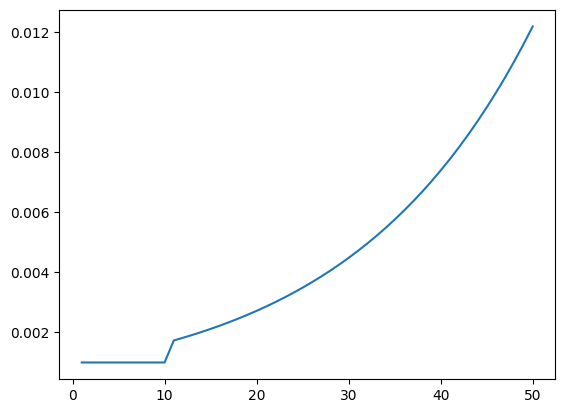

In [35]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 51, 1)]
lrate = [scheduler(i) for i in range(1, 51, 1)]
plt.plot(epochs, lrate)

In [36]:
model_path='artifacts/models/crnn/crnn_best_12.h5'

callbacks = [
    #tf.keras.callbacks.LearningRateScheduler(scheduler),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath="artifacts/models/crnn/crnn_epoch_2_{epoch:02d}.h5", save_best_only=False, verbose=1, save_weights_only=False)
    #tf.keras.callbacks.ModelCheckpoint(filepath=model_path, monitor='val_loss', save_best_only=True, verbose=1, mode='min', save_weights_only=False)
]

In [37]:
for sample in train_dataset.take(1):
    print(sample['image'])


tf.Tensor(
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0

In [38]:
model.fit(train_dataset,validation_data=test_dataset,callbacks=callbacks,epochs=30)

Epoch 1/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 1903.4662
Epoch 1: saving model to artifacts/models/crnn/crnn_epoch_2_01.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1136s 5s/step - loss: 1900.9066 - val_loss: 1174.0496 - learning_rate: 7.0000e-04
Epoch 2/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 833.1409
Epoch 2: saving model to artifacts/models/crnn/crnn_epoch_2_02.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1053s 5s/step - loss: 832.6072 - val_loss: 573.4059 - learning_rate: 7.0000e-04
Epoch 3/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 371.8247
Epoch 3: saving model to artifacts/models/crnn/crnn_epoch_2_03.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1068s 5s/step - loss: 371.5173 - val_loss: 227.3495 - learning_rate: 7.0000e-04
Epoch 4/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 176.9365
Epoch 4: saving model to artifacts/models/crnn/crnn_epoch_2_04.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1068s 5s/step - loss: 176.8507 - val_loss: 177.6475 - learning_rate: 7.0000e-04
Epoch 5/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 114.3500
Epoch 5: saving model to artifacts/models/crnn/crnn_epoch_2_05.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1057s 5s/step - loss: 114.3014 - val_loss: 125.8943 - learning_rate: 7.0000e-04
Epoch 6/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 82.5732
Epoch 6: saving model to artifacts/models/crnn/crnn_epoch_2_06.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 1052s 5s/step - loss: 82.5411 - val_loss: 138.6949 - learning_rate: 7.0000e-04
Epoch 7/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 61.4598
Epoch 7: saving model to artifacts/models/crnn/crnn_epoch_2_07.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 978s 4s/step - loss: 61.4355 - val_loss: 114.1613 - learning_rate: 7.0000e-04
Epoch 8/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 46.9882
Epoch 8: saving model to artifacts/models/crnn/crnn_epoch_2_08.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 951s 4s/step - loss: 46.9777 - val_loss: 105.2774 - learning_rate: 7.0000e-04
Epoch 9/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 39.1940
Epoch 9: saving model to artifacts/models/crnn/crnn_epoch_2_09.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 960s 4s/step - loss: 39.1824 - val_loss: 99.7979 - learning_rate: 7.0000e-04
Epoch 10/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 30.1220
Epoch 10: saving model to artifacts/models/crnn/crnn_epoch_2_10.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 962s 4s/step - loss: 30.1157 - val_loss: 110.1869 - learning_rate: 7.0000e-04
Epoch 11/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 26.3294
Epoch 11: ReduceLROnPlateau reducing learning rate to 6.99999975040555e-05.

Epoch 11: saving model to artifacts/models/crnn/crnn_epoch_2_11.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 955s 4s/step - loss: 26.3244 - val_loss: 124.5160 - learning_rate: 7.0000e-04
Epoch 12/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 17.3690
Epoch 12: saving model to artifacts/models/crnn/crnn_epoch_2_12.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 947s 4s/step - loss: 17.3457 - val_loss: 65.2799 - learning_rate: 7.0000e-05
Epoch 13/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 7.7048
Epoch 13: saving model to artifacts/models/crnn/crnn_epoch_2_13.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 942s 4s/step - loss: 7.6974 - val_loss: 64.4613 - learning_rate: 7.0000e-05
Epoch 14/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 4.9630
Epoch 14: saving model to artifacts/models/crnn/crnn_epoch_2_14.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 945s 4s/step - loss: 4.9586 - val_loss: 65.3034 - learning_rate: 7.0000e-05
Epoch 15/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 3.5904
Epoch 15: ReduceLROnPlateau reducing learning rate to 6.999999459367246e-06.

Epoch 15: saving model to artifacts/models/crnn/crnn_epoch_2_15.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 946s 4s/step - loss: 3.5874 - val_loss: 66.6861 - learning_rate: 7.0000e-05
Epoch 16/30
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 3.0731
Epoch 16: saving model to artifacts/models/crnn/crnn_epoch_2_16.h5


225/225 ━━━━━━━━━━━━━━━━━━━━ 947s 4s/step - loss: 3.0702 - val_loss: 65.3973 - learning_rate: 7.0000e-06
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 13.


In [39]:
pred=model.predict(test_dataset)

75/75 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step


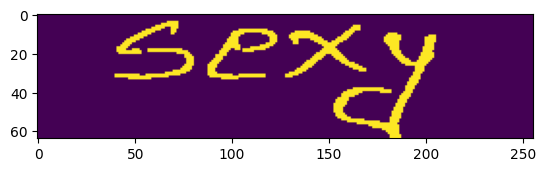

In [40]:
import matplotlib.pyplot as plt

for batch in test_dataset.take(1):
    images=batch['image']

    #img=(images[22]*255).numpy().astype('uint8')
    img=images[12]

    plt.imshow(img)


In [41]:
ctc_decoder(pred)

['of',
 'estimated',
 'that',
 'with',
 'a',
 'composed',
 'is',
 'in',
 'that',
 '1968',
 'Convention',
 'feeling',
 '364',
 'hell',
 'the',
 'the',
 'a',
 'fson',
 'are',
 '2009',
 'the',
 'and',
 'banke',
 'is',
 'are',
 '62270',
 'too',
 '29578',
 'of',
 'acting',
 'Sakopeon',
 '2',
 'his',
 'pattern',
 'the',
 'first',
 'with',
 '1953',
 'also',
 'dixperent',
 'neven',
 'He',
 'the',
 '2020',
 'Can',
 'the',
 'the',
 '52253',
 'viswally',
 'the',
 'the',
 '12935',
 'eastle',
 'aftr',
 'cashier',
 'to',
 'moecules',
 'as',
 'The',
 'had',
 'as',
 'Alatama',
 'to',
 'held',
 '6807',
 'highness',
 'aggressive',
 'attitudes',
 'the',
 'largest',
 'the',
 'his',
 'the',
 'almost',
 'A',
 'time',
 'rested',
 'and',
 'the',
 'including',
 'name',
 '54642',
 'of',
 'Even',
 'the',
 'of',
 'famous',
 'opened',
 '28277',
 'But',
 'them',
 '24787',
 'repres',
 'best',
 'dedicated',
 '94302',
 'hin',
 'Nikos',
 'the',
 'is',
 'thenn',
 'when',
 'time',
 'with',
 'was',
 'in',
 'the',
 '64588'

In [42]:
test_img_path[22]

'artifacts/Dataset/Word_Level_Training_Set/image/2747_14.jpg'

# **Model Prediction**

In [50]:
def crnn_pred():
    inputs = Input(shape=(64, 256, 1), name="image")

    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    conv_1 = Conv2D(32, (3,3), activation = "selu", padding='same')(inputs)
    pool_1 = MaxPool2D(pool_size=(2, 2))(conv_1)
    
    conv_2 = Conv2D(64, (3,3), activation = "selu", padding='same')(pool_1)
    pool_2 = MaxPool2D(pool_size=(2, 2))(conv_2)

    conv_3 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_2)
    pool_3 = MaxPool2D(pool_size=(2, 2))(conv_3)

    conv_4 = Conv2D(128, (3,3), activation = "selu", padding='same')(pool_3)
    pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
    
    conv_5 = Conv2D(256, (3,3), activation = "selu", padding='same')(pool_4)
    
    # Batch normalization layer
    batch_norm_5 = BatchNormalization()(conv_5)
    
    conv_6 = Conv2D(256, (3,3), activation = "selu", padding='same')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv_6)
    pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
    
    conv_7 = Conv2D(64, (2,2), activation = "selu")(pool_6)
    
    squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
    
    # bidirectional LSTM layers with units=128
    blstm_1 = Bidirectional(LSTM(128, return_sequences=True))(squeezed)
    blstm_2 = Bidirectional(LSTM(128, return_sequences=True))(blstm_1)

    output = Dense(62 + 1, activation = 'softmax', name="dense")(blstm_2)

    model = Model(inputs=inputs, outputs=output)

    return model   

In [51]:
crnn_pred=crnn_pred()

In [52]:
crnn_pred.load_weights("artifacts/models/crnn/crnn_epoch_2_12.h5")

In [53]:
crnn_pred.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 64, 256, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 256, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 32, 128, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 128, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 16, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 8, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 32, 128)     │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 4, 32, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 4, 32, 256)     │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 4, 32, 256)     │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 32, 256)     │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 2, 32, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 1, 31, 64)      │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 31, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 31, 256)        │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 31, 256)        │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 31, 63)         │        16,191 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,801,215 (6.87 MB)

 Trainable params: 1,800,191 (6.87 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [57]:
#img=get_image('artifacts/Dataset/Word_Level_Training_Set/image/3576_14.jpg')
idx=15324

img=get_image(img_path[idx])

print(text_labels[idx])
print(encode_to_label(text_labels[idx]))

img = np.expand_dims(img, axis=0) 

print(img.shape)

lived
[47 44 57 40 39 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62 62
 62 62]
(1, 64, 256, 1)


In [58]:
prediction=crnn_pred.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [60]:
import pandas as pd
pred_df= pd.DataFrame(prediction.reshape(31,63))

np.argmax(pred_df.values, axis=1)

array([47, 62, 62, 62, 62, 62, 62, 62, 62, 62, 44, 44, 57, 62, 57, 62, 62,
       40, 40, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 62, 39])

In [59]:
ctc_decoder(prediction)

['livved']

# **Text recognition**

In [28]:
import matplotlib.pyplot as plt

def get_image_0(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    return img

def get_word_coordinates(coord_path):
    word_coordinates=[]
    with open(coord_path,'r') as file:
        lines=file.readlines()

        for line in lines:
            line=line.replace('\n','')
            if line!='':
                coord=line.split(',')
                coord=list(map(int,coord))
                word_coordinates.append(coord)
    
    word_coordinates = np.array(word_coordinates)

    boxes = sorted(word_coordinates, key=lambda x: x[1])  # x[1] is the top-left y-coordinate

    # Group boxes into lines based on y-distance threshold
    lines = []
    current_line = [boxes[0]]
    
    threshold=0.5
    for i in range(1, len(boxes)):
        max_height_index=0
        max_height=0
        for j in range(len(current_line)):
            word_height=abs(max(np.array(current_line[j])[[1, 3, 5, 7]]) - min(np.array(current_line[j])[[1, 3, 5, 7]]))
            if word_height>max_height:
                max_height=word_height
                max_height_index=j

        if abs(boxes[i][1] - current_line[max_height_index][1]) < threshold*max_height:  # Adjust threshold as needed
            current_line.append(boxes[i])
        else:
            lines.append(sorted(current_line, key=lambda x: x[0]))  # Sort by x-coordinates (left to right)
            current_line = [boxes[i]]
        
    
    lines.append(sorted(current_line, key=lambda x: x[0]))

    # print(len(lines))
    # for line in lines:
    #     print(f'{line}\n')

    # Flatten the list of sorted lines
    sorted_boxes = [box for line in lines for box in line]
    
    return sorted_boxes

def get_each_word_image(img:np.ndarray,coord:list):
    x1,y1,x2,y2,x3,y3,x4,y4=coord
    
    x_start=min(x1,x4)
    y_start=min(y1,y2)

    x_end=max(x2,x3)
    y_end=max(y3,y4)

    cropped_img=img[y_start:y_end+1,x_start:x_end+1]

    return cropped_img

def resize_image_0(img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR):
    height,width,channels=img.shape
    target_height64=canvas_size[0]
    target_width128=canvas_size[1]

    if width>height:
        temp_ratio=target_width128/width
        if int(temp_ratio*height)>target_height64:
            ratio=target_height64/height
        else:
            ratio=temp_ratio
    else:
        temp_ratio=target_height64/height
        if int(temp_ratio*width)>target_width128:
            ratio=target_width128/width
        else:
            ratio=temp_ratio
    target_h=int(ratio*height)
    target_w=int(ratio*width)
    #proc=cv2.resize(img,(target_w,target_h),interpolation=interpolation)
    proc=cv2.resize(img,(256,64),interpolation=interpolation) #original resize size is (128,32)
    proc=np.expand_dims(proc, axis=-1)

    #resized=np.zeros((target_height64, target_width128, channels),dtype=np.float32)
    #resized[:target_h,:target_w]=proc

    return proc

def image_transformation(img):
    img = cv2.bitwise_not(img)

    img = np.expand_dims(img, axis=-1)

    img=resize_image(img)

    blur = cv2.GaussianBlur(img, (1,1), 0)

    _, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    img = binary_img.astype(np.float32) / 255.0  

    """ kernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness

    # Apply dilation to thicken text
    thickened_text = cv2.dilate(img, kernel, iterations=1)

    thickened_text = np.expand_dims(thickened_text, axis=-1) """

    kernel = np.ones((2,2), np.uint8)

    # Apply erosion
    thinned_img = cv2.erode(img, kernel, iterations=1)

    thinned_img = np.expand_dims(thinned_img, axis=-1)

    return thinned_img

def cropped_images(result_path):
    img=get_image_0(os.path.join(result_path,'demo_transformed.jpg'))
    word_coordinates=get_word_coordinates(os.path.join(result_path,'res_demo_transformed.txt'))

    cropped_images=[]
    for coord in word_coordinates:
        
        cropped_img=get_each_word_image(img,coord)
        transformed_img=image_transformation(cropped_img)
        
        cropped_images.append(transformed_img)

    return cropped_images



images=cropped_images(result_path='artifacts/image/result')

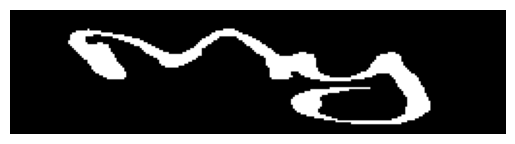

In [29]:
plt.imshow(images[0], cmap='gray')  # Use cmap='gray' for grayscale images if needed
plt.axis('off')  # Remove axes for better visualization
plt.show() 

In [32]:
""" predictions=[]
for img in images:
    img = np.expand_dims(img, axis=0) 
    pred=crnn_pred.predict(img)
    predictions.append(pred) """
    
predictions=crnn_pred.predict(np.array(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step


In [33]:
#decoded_predictions=[]
# for item in predictions:
#     decoded_item=ctc_decoder(item)
#     decoded_item=''.join(decoded_item)
#     decoded_predictions.append(decoded_item)

decoded_predictions=ctc_decoder(predictions)

In [34]:
decoded_predictions

['my',
 'name',
 'is',
 'mnanst',
 'wat',
 'is',
 'youy',
 'name',
 'tow',
 'ase',
 'you',
 'doiy']

In [35]:
text=' '.join(decoded_predictions)

print(text)

my name is mnanst wat is youy name tow ase you doiy


## Applying NLP techniques to post process the text

In [36]:
from spellchecker import SpellChecker

spell = SpellChecker()

def correct_spelling(text):
    words = text.split()
    corrected = [spell.correction(word) for word in words]
    return " ".join(corrected)

correct_spell_text=correct_spelling(text)
print(correct_spell_text)

my name is means wat is you name tow are you dozy


# **Analysing pixel value distribution**

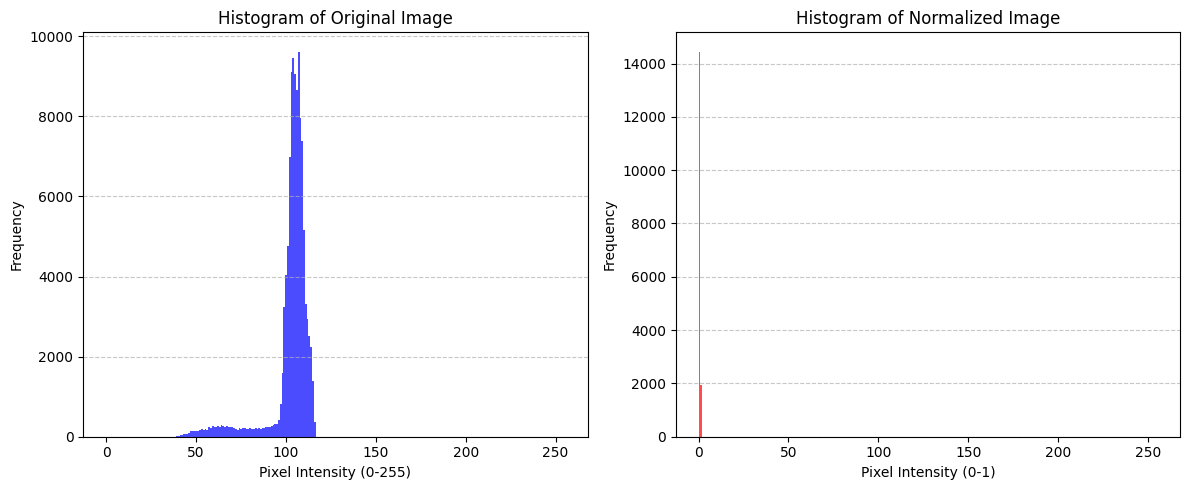

In [54]:
img_1 = cv2.imread('artifacts/Dataset/Word_Level_Training_Set/image/12155_2.jpg', cv2.IMREAD_GRAYSCALE)
img_2=images[0]

# Flatten image to 1D array
pixel_values_1 = img_1.flatten()
pixel_values_2 = img_2.flatten()
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Original Image Histogram
axes[0].hist(pixel_values_1, bins=256, range=(0, 255), color='blue', alpha=0.7)
axes[0].set_title("Histogram of Original Image")
axes[0].set_xlabel("Pixel Intensity (0-255)")
axes[0].set_ylabel("Frequency")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Normalized Image Histogram
axes[1].hist(pixel_values_2, bins=256, range=(0, 255), color='red', alpha=0.7)
axes[1].set_title("Histogram of Normalized Image")
axes[1].set_xlabel("Pixel Intensity (0-1)")
axes[1].set_ylabel("Frequency")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


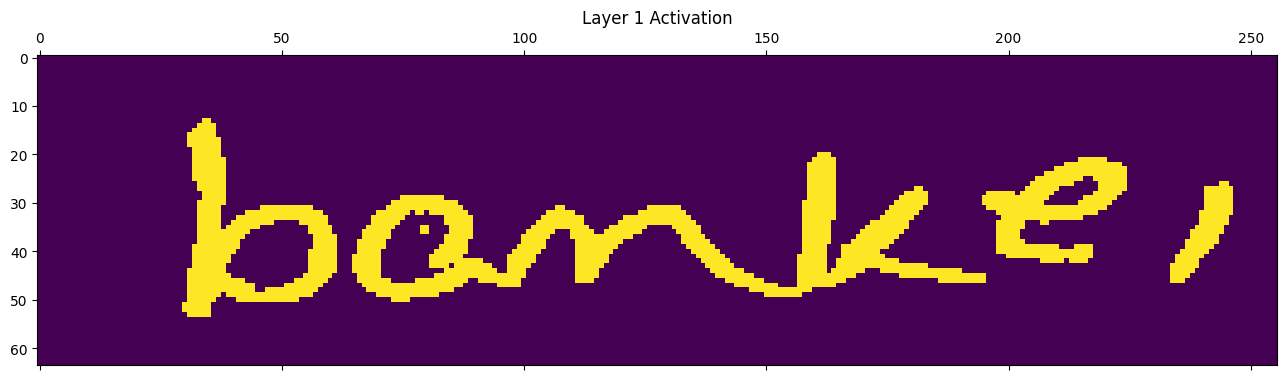

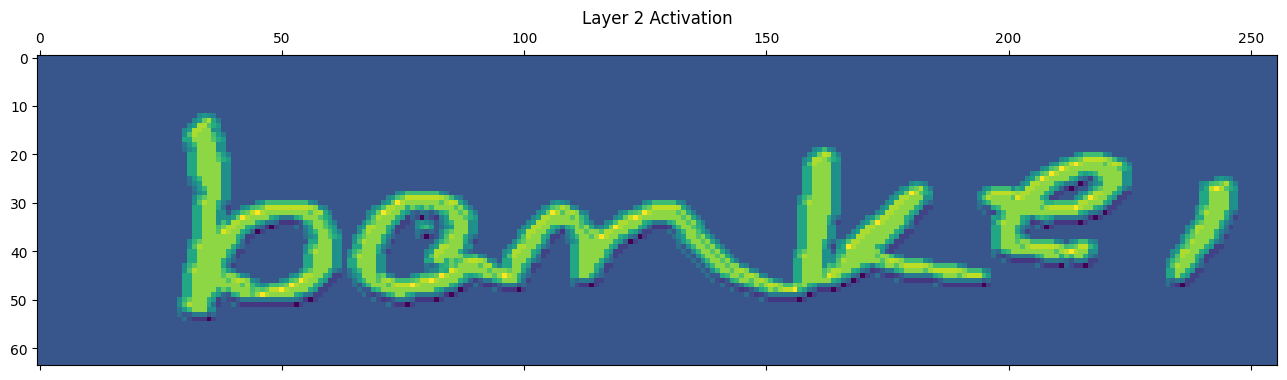

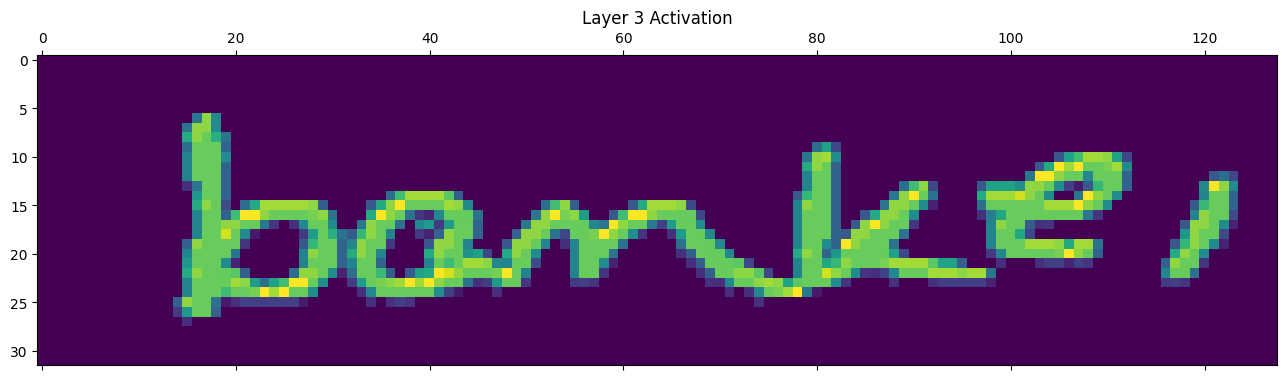

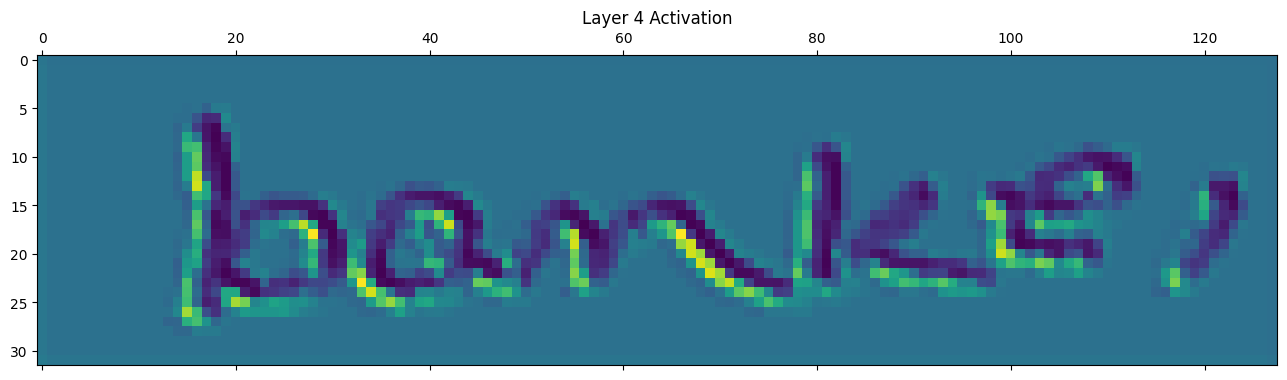

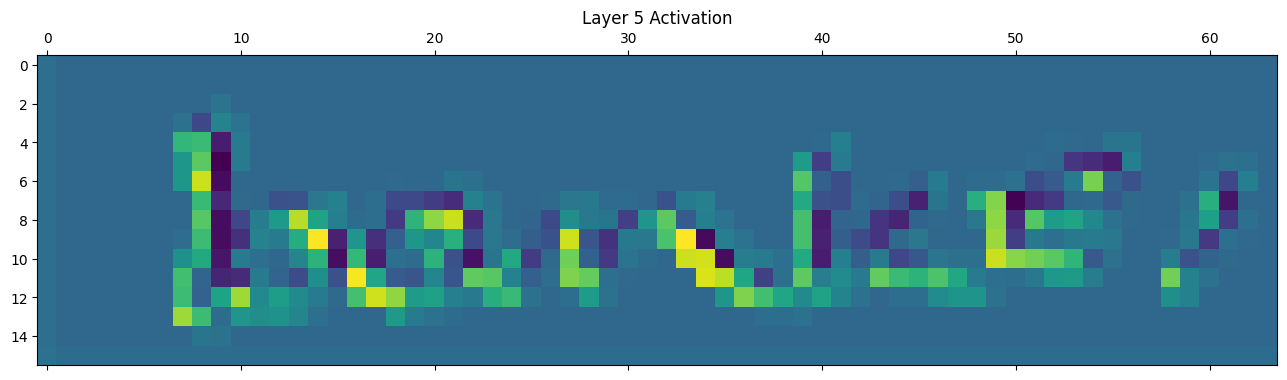

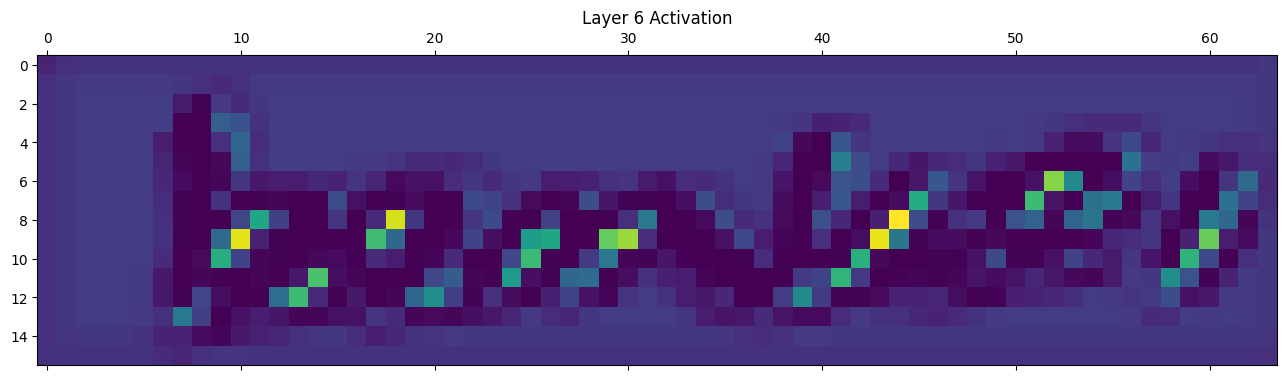

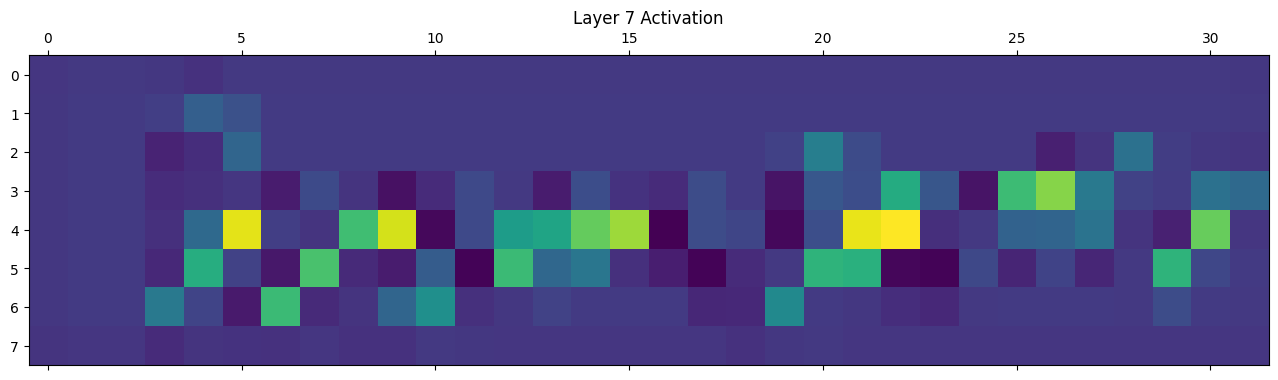

In [55]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

img=get_image('artifacts/Dataset/Word_Level_Training_Set/image/2747_14.jpg')
img = np.expand_dims(img, axis=0) 

layer_outputs = [layer.output for layer in crnn_pred.layers[:7]]  # First few layers
activation_model = Model(inputs=crnn_pred.input, outputs=layer_outputs)
activations = activation_model.predict(img)

for i, activation in enumerate(activations):
    plt.matshow(activation[0, :, :, 0], cmap='viridis')
    plt.title(f"Layer {i+1} Activation")
    plt.show()


# **Modular Code**

In [69]:
#entity
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TextRecognitionConfig:
    crnn_weights: Path
    crnn_input_path: Path
    crnn_output_path: Path
    resize_canvas: tuple
    sorting_threshold: float
    no_of_char: int
    char_list: list

In [70]:
#config
from mlOCR.constants import *
from mlOCR.utils.common import read_yaml,create_directories
from pathlib import Path

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_text_recognition_config(self)->TextRecognitionConfig:
        config=self.config.text_recognition
        params=self.params.text_recognition

        create_directories([config.crnn_output_path])

        text_recognition_config=TextRecognitionConfig(
            crnn_weights=Path(config.crnn_weights),
            crnn_input_path=Path(config.crnn_input_path),
            crnn_output_path=Path(config.crnn_output_path),
            resize_canvas=tuple(map(int,params.resize_canvas.translate(str.maketrans('','','()')).split(','))),
            sorting_threshold=float(params.sorting_threshold),
            no_of_char=int(params.no_of_char),
            char_list=params.char_list
        )

        return text_recognition_config

In [ ]:
#component

from itertools import groupby
from mlOCR.models.crnn_pred import crnn_pred_model
from mlOCR.utils.common import save_text_file

class TextRecognition:
    def __init__(self, TextRecognitionConfig):
        self.crnn_weights=TextRecognitionConfig.crnn_weights
        self.crnn_input_path=TextRecognitionConfig.crnn_input_path
        self.crnn_output_path=TextRecognitionConfig.crnn_output_path
        self.resize_canvas=TextRecognitionConfig.resize_canvas
        self.sorting_threshold=TextRecognitionConfig.sorting_threshold
        self.no_of_char=TextRecognitionConfig.no_of_char
        self.char_list=TextRecognitionConfig.char_list
    
    def get_image(self,img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        return img

    def get_word_coordinates(self,coord_path):
        word_coordinates=[]
        with open(coord_path,'r') as file:
            lines=file.readlines()

            for line in lines:
                line=line.replace('\n','')
                if line!='':
                    coord=line.split(',')
                    coord=list(map(int,coord))
                    word_coordinates.append(coord)
        
        word_coordinates = np.array(word_coordinates)

        boxes = sorted(word_coordinates, key=lambda x: x[1])  # x[1] is the top-left y-coordinate

        # Group boxes into lines based on y-distance threshold
        lines = []
        current_line = [boxes[0]]
        
        threshold=self.sorting_threshold
        # threshold=0.5
        for i in range(1, len(boxes)):
            max_height_index=0
            max_height=0
            for j in range(len(current_line)):
                word_height=abs(max(np.array(current_line[j])[[1, 3, 5, 7]]) - min(np.array(current_line[j])[[1, 3, 5, 7]]))
                if word_height>max_height:
                    max_height=word_height
                    max_height_index=j

            if abs(boxes[i][1] - current_line[max_height_index][1]) < threshold*max_height:  # Adjust threshold as needed
                current_line.append(boxes[i])
            else:
                lines.append(sorted(current_line, key=lambda x: x[0]))  # Sort by x-coordinates (left to right)
                current_line = [boxes[i]]
            
        
        lines.append(sorted(current_line, key=lambda x: x[0]))

        # print(len(lines))
        # for line in lines:
        #     print(f'{line}\n')

        # Flatten the list of sorted lines
        sorted_boxes = [box for line in lines for box in line]
        
        return sorted_boxes

    def get_each_word_image(self,img:np.ndarray,coord:list):
        x1,y1,x2,y2,x3,y3,x4,y4=coord
        
        x_start=min(x1,x4)
        y_start=min(y1,y2)

        x_end=max(x2,x3)
        y_end=max(y3,y4)

        cropped_img=img[y_start:y_end+1,x_start:x_end+1]

        return cropped_img

    def resize_image(self, img, canvas_size=(32,128),interpolation=cv2.INTER_LINEAR):
        permuted_canvas_size = canvas_size[::-1]  #(h,w) to (w,h)
        proc=cv2.resize(img,permuted_canvas_size,interpolation=interpolation) #original resize size is (128,32)
        proc=np.expand_dims(proc, axis=-1)

        return proc

    def image_transformation(self, img):
        img = cv2.bitwise_not(img)

        img = np.expand_dims(img, axis=-1)

        img=self.resize_image(img,canvas_size=self.resize_canvas)

        blur = cv2.GaussianBlur(img, (1,1), 0)

        _, binary_img = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        img = binary_img.astype(np.float32) / 255.0  

        """ kernel = np.ones((2, 2), np.uint8)  # You can adjust the kernel size for more thickness

        # Apply dilation to thicken text
        thickened_text = cv2.dilate(img, kernel, iterations=1)

        thickened_text = np.expand_dims(thickened_text, axis=-1) """

        kernel = np.ones((2,2), np.uint8)

        # Apply erosion
        thinned_img = cv2.erode(img, kernel, iterations=1)

        thinned_img = np.expand_dims(thinned_img, axis=-1)

        return thinned_img

    def cropped_images(self):
        img=self.get_image(os.path.join(self.crnn_input_path,'demo_transformed.jpg'))
        word_coordinates=self.get_word_coordinates(os.path.join(self.crnn_input_path,'res_demo_transformed.txt'))

        cropped_images=[]
        for coord in word_coordinates:
            
            cropped_img=self.get_each_word_image(img,coord)
            transformed_img=self.image_transformation(cropped_img)
            
            cropped_images.append(transformed_img)

        return cropped_images
    
    def ctc_decoder(self, predictions):
        '''
        input: given batch of predictions from text rec model
        output: return lists of raw extracted text

        '''
        length=self.no_of_char
        char_list=self.char_list
        text_list = []
        
        pred_indcies = np.argmax(predictions, axis=2)
        
        for i in range(pred_indcies.shape[0]):
            ans = ""
            
            ## merge repeats
            merged_list = [k for k,_ in groupby(pred_indcies[i])]
            
            ## remove blanks
            for p in merged_list:
                if p != length:
                    ans += char_list[int(p)]
            
            text_list.append(ans)
            
        return text_list
    
    def get_predictions(self, cropped_images: list):
        crnn_pred=crnn_pred_model()
        crnn_pred.load_weights(self.crnn_weights)
        predictions=crnn_pred.predict(np.array(cropped_images))
        decoded_predictions=self.ctc_decoder(predictions)
        text=' '.join(decoded_predictions)

        return text
    
    def save_results(self, text: str):
        save_text_file(text=text, filename='crnn_raw_text.txt', path=self.crnn_output_path)

In [72]:
#pipeline
#from mlOCR.config.configuration import ConfigurationManager
from mlOCR import logger
#from mlOCR.components.text_recognition import TextRecognition

try:
    config_manager=ConfigurationManager()
    text_recognition_config=config_manager.get_text_recognition_config()
    text_recognition=TextRecognition(text_recognition_config)
    cropped_images=text_recognition.cropped_images()
    text=text_recognition.get_predictions(cropped_images=cropped_images)
    text_recognition.save_results(text=text)
except Exception as e:
    logger.exception(e)
    raise e

[2025-04-06 11:11:31,493: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-06 11:11:31,532: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-06 11:11:31,537: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-06 11:11:31,540: INFO: common: created directory at: artifacts]
[2025-04-06 11:11:31,543: INFO: common: created directory at: artifacts/output/crnn]
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
(256, 64) <class 'tuple'>
[2025-04-06 11:11:32,392: WARNING: polymorphic_function: 5 out of the last 17 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CDBF631300> triggered tf.function retracing. Tracing is expensive and the excessive n

## Post processing

In [73]:
# entity
@dataclass(frozen=True)
class TextPostProcessingConfig:
    text_input_path: Path

In [74]:
#config
from mlOCR.constants import *
from mlOCR.utils.common import read_yaml,create_directories
from pathlib import Path

class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH,
        schema_filepath = SCHEMA_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        self.schema = read_yaml(schema_filepath)

        create_directories([self.config.artifacts_root])

    def get_text_post_processing_config(self)->TextPostProcessingConfig:
        config=self.config.text_post_processing

        text_post_processing_config=TextPostProcessingConfig(
            text_input_path=Path(config.text_input_path)
        )

        return text_post_processing_config

In [77]:
#component
from mlOCR.utils.common import load_text_file
import os

class TextPostProcessing:
    def __init__(self, TextPostProcessingConfig):
        self.text_input_path=TextPostProcessingConfig.text_input_path

    def correct_spelling(self, text):
        words = text.split()
        corrected = [spell.correction(word) for word in words]
        corrected_text=" ".join(corrected)
        return corrected_text

    def get_text(self)->str:
        text=load_text_file(Path(os.path.join(self.text_input_path,'crnn_raw_text.txt')))
        
        return text

In [78]:
try:
    config_manager=ConfigurationManager()
    text_post_processing_config=config_manager.get_text_post_processing_config()
    text_post_processing=TextPostProcessing(text_post_processing_config)
    text=text_post_processing.get_text()
    corrected_text=text_post_processing.correct_spelling(text=text)
    print(corrected_text)
except Exception as e:
    logger.exception(e)
    raise e

[2025-04-06 11:34:16,677: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-04-06 11:34:16,694: INFO: common: yaml file: params.yaml loaded successfully]
[2025-04-06 11:34:16,699: INFO: common: yaml file: schema.yaml loaded successfully]
[2025-04-06 11:34:16,702: INFO: common: created directory at: artifacts]
[2025-04-06 11:34:16,708: INFO: common: Text file loaded from: artifacts\output\crnn\crnn_raw_text.txt]
my name is means wat is you name tow are you dozy
